# Modeling a Gas Pipeline in JuMP
### Jordan Jalving & Victor Zavala



## Import JuMP and Ipopt

In [2]:
using JuMP
using Ipopt
using PyPlot

## Set physical property information
Physical property information includes gas compressibility, pipe rugosity, etc...
We also include conversion factors for units.  Using typical gas pipeline units often results in a badly scaled optimization problem.  We convert quantities to units such that all numeric values are within the same relative orders of magnitude

In [3]:
# physical property data
eps= 0.025		             # pipe rugosity - [mm]
z= 0.80        			     # gas compressibility  - []
rhon=0.72         		     # density of air at normal conditions - [kg/m3]
R=8314.0       			     # universal gas constant [J/kgmol-K]
M=18.0    			         # gas molar mass [kg/kgmol]
pi=3.14         		     # pi
T=293.15      		         # reference temperature [K]
Cp=2.34        		         # heat capacity @ constant pressure [kJ/kg-K]
Cv=1.85        		         # heat capacity @ constant volume [kJ/kg-K]

#scaling factors
ffac=(1e+6*rhon)/(24*3600)                     # from scmx10-6/day to kg/s
ffac2=(3600)/(1e+4*rhon)                       # from kg/s to scmx10-4/hr
pfac=1e+5                                      # from bar to Pa
pfac2=1e-5                                     # from Pa to bar
dfac=1e-3                                      # from mm to m
lfac=1e+3;                                     # from km to m

# The Pipeline Model

$\newcommand{\norm}[1]{\left\lvert#1\right\rvert}$
__Objective__ (Minimize compressor cost and maximize gas delivered)

$
\min \varphi:=\int_{0}^T \left(\alpha_{P} P(t)-\alpha_{gas} d_{deliver}(t)\right)dt
$


__Isothermal Euler Equations__

$
\begin{align*}
     &\frac{\partial p(t,x)}{\partial t} + \frac{c^2}{A}\frac{\partial f(t,x)}{\partial x} = 0\\
      &\frac{\partial f(t,x)}{\partial t} + \frac{2c^2f(t,x)}{Ap(t,x)}\frac{\partial f(t,x)}{\partial x} - \frac{c^2f(t,x)^2}{Ap(t,x)^2}\frac{\partial p(t,x)}{\partial x}
          + A\frac{\partial p(t,x)}{\partial x} = -\frac{8c^2\lambda A}{\pi^2D^5}\frac{f(t,x)}{p(t,x)} \norm{f(t,x)}
    \end{align*}
$

__Compressor Equation__

$
\begin{align*}
P(t)= c_p\cdot T\cdot f_{in}(t)\cdot\left(\left(\frac{p_{in}(t)+\Delta p(t) }{p_{in}(t)}\right)^{\frac{\gamma-1}
{\gamma}}-1\right)
\end{align*}
$

__Boundary Conditions__

$
\begin{align*}
&p(L,t)=p_{out}(t)\\
&p(0,t)=p_{in}(t)+\Delta p(t)
\end{align*}
$
$
\begin{align*}
&f(L,t)=f_{out}(t)\\
&f(0,t)=f_{in}(t)
\end{align*}
$

__Gas Demand Relations__

$
\begin{align*}
&f_{out}(t) = d_{deliver}(t)\\
&d_{deliver}(t) \le d_{target}(t)
\end{align*}
$


## Set pipeline parameters

In [4]:
#parameters
diameter = 0.92
pipe_length = 60000
area = (1/4)*pi*diameter*diameter
lam = (2*log10(3.7*diameter/(eps*dfac)))^(-2); 

#other calculated constants
gam = Cp/Cv       		     	# expansion coefficient [-]
nu2 = gam*z*R*T/M  			    # gas speed of sound
om = (gam-1.0)/gam 		     	# aux constant [-]
c4 = (1/ffac2)*(Cp*T)
#lumped constants for pipeline
c1 = (pfac2/ffac2)*(nu2/area)
c2 = area*(ffac2/pfac2)
c3 = area*(pfac2/ffac2)*(8*lam*nu2)/(pi*pi*diameter^5);

## Create time grid, spatial grid, and time horizon for optimization
We consider a time horizon of 24 hours with a resolution of one hour

We consider a spatial grid of 10 points over the length of the pipeline

In [5]:
horizon = 24*3600;                       # horizon length
time_grid = 1:24;                        # set of temporal mesh points
x_grid = 1:10;                           # set of spatial mesh 
dx = pipe_length / (length(x_grid) - 1)  # equally spaced spatial grid points
dt = horizon / length(time_grid);        # equally spaced time grid points

## Create demand profile data
We consider a constant gas demand and introduce a pulse from hours 10 to 15

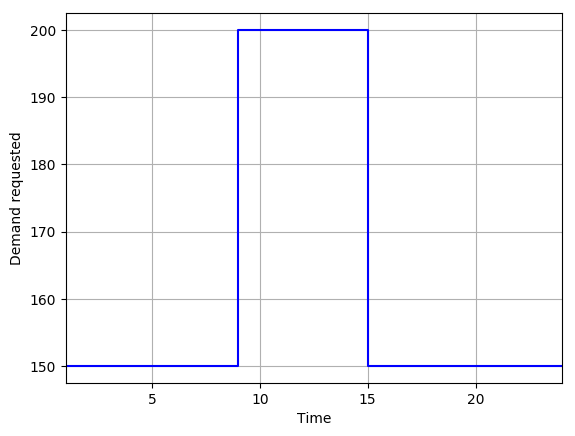

In [6]:
gas_demands = fill(150,length(time_grid))
gas_demands[10:15] = 200
step(time_grid,gas_demands,color="blue")
ax = gca()
ax[:set_xlim]([1,24])
xlabel("Time")
ylabel("Demand requested")
grid("on")

## Define pipeline variables

In [7]:
m = Model(solver = IpoptSolver())
#Define inlet, outlet, and flow variables
@variable(m,pin[time_grid] >= 10, start = 60)
@variable(m,pout[time_grid] >=10, start = 60)
@variable(m,fin[time_grid] >=0, start = 100)
@variable(m,fout[time_grid] >= 0, start = 100)
@variable(m, px[time_grid,x_grid] >= 0, start = 60)
@variable(m, fx[time_grid,x_grid] >= 0, start = 10)
# Couple flow convenience variables
@constraint(m, flow_in[t = time_grid],  fx[t,1] == fin[t])
@constraint(m, flow_out[t = time_grid], fx[t,x_grid[end]] == fout[t]);

## Gas demand variables and constraints

In [8]:
@variable(m,ddeliver[time_grid] >= 0, start = 100)
@variable(m, dtarget[time_grid] >= 0)
@constraint(m, gasLimit[t = time_grid], ddeliver[t] <= dtarget[t]);
@constraint(m,deliver[t=time_grid],fout[t] == ddeliver[t])
@constraint(m, demand[t = time_grid], dtarget[t] == gas_demands[t]);

## Compressor variables and equation

In [9]:
@variable(m, dp[time_grid] >= 0 , start = 10)
@variable(m, pow[time_grid] >= 0, start = 500);
@NLconstraint(m, powereqn[t = time_grid], pow[t] == c4*fin[t]*(((pin[t]+dp[t])/pin[t])^om-1));

## Define PDE equations
Here we define the isothermal euler equations, as well as the appropriate boundary conditions and initial condition.  Since we have 2 first order hyperbolic PDEs, we require 2 boundary conditions and initial conditions

In [10]:
#Auxillary variables
@variable(m, slack1[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable 
@variable(m, slack2[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable
@variable(m, slack3[time_grid,x_grid] >= 0, start = 10)  #auxiliary variable

#Auxillary constraints (let's us avoid the fractional terms)
@NLconstraint(m, slackeq1[t = time_grid, x = x_grid],  slack1[t,x]*px[t,x] - c3*fx[t,x]*fx[t,x] == 0)
@NLconstraint(m, slackeq2[t = time_grid, x = x_grid],  slack2[t,x]*px[t,x] - 2*c1*fx[t,x] == 0)
@NLconstraint(m, slackeq3[t = time_grid, x = x_grid],  slack3[t,x]*px[t,x]*px[t,x] - c1*fx[t,x]*fx[t,x] == 0)

#PDE equations
@constraint(m, mass[t = time_grid[1:end-1], x = x_grid[1:end-1]], 
    (px[t+1,x]-px[t,x])/dt + c1*(fx[t+1,x+1]-fx[t+1,x])/dx == 0 )
@constraint(m, momentum[t = time_grid[1:end-1], x = x_grid[1:end-1]], 
    (fx[t+1,x]-fx[t,x])/dt == -slack2[t+1,x]*(fx[t+1,x+1]-fx[t+1,x])/dx +
                            slack3[t+1,x]*(px[t+1,x+1]-px[t+1,x])/dx -c2*(px[t+1,x+1]-px[t+1,x])/dx - slack1[t+1,x])

#Boundary Conditions
@constraint(m,p_in[t = time_grid],  pin[t] == 50)
@constraint(m,press_in[t = time_grid],  px[t,1] == pin[t] + dp[t])
@constraint(m,press_out[t = time_grid], px[t,x_grid[end]] == pout[t])

#Initial Conditions
@constraint(m, mass_ss[t = 1, x = x_grid[1:end-1]],(fx[t,x+1] - fx[t,x]) == 0)
@constraint(m, momentum_ss[t = 1, x = x_grid[1:end-1]], -c2*(px[t,x+1] - px[t,x])/dx - slack1[t,x] == 0);

## Periodic terminal constraint
This avoids solutions that deplete the gas in the pipeline

In [11]:
#Periodic terminal constraint
@variable(m,linepack[time_grid])
@constraint(m,linepack_def[t = time_grid],linepack[t] == sum(fx[t,x] for x in x_grid)*dx)
@constraint(m,linepack_cons, linepack[time_grid[end]] >= linepack[time_grid[1]]);

## Objective function terms

In [12]:
compressor_cost = 0.1  # compression cost in USD/kWh
@variable(m, powercost)
@constraint(m,boostcosteqn, powercost == sum(compressor_cost*pow[t] for t = time_grid)*dt/3600)

gas_cost = 1000        # value of gas delivered
@variable(m, demandcost)
@constraint(m, integratedGasCost, demandcost == sum(gas_cost*ddeliver[t] for t = time_grid));

## Objective function (minimize compressor cost and maximize gas delivered)

In [13]:
@objective(m,Min,powercost - demandcost);

## Solve the model with Ipopt

In [14]:
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6446
Number of nonzeros in inequality constraint Jacobian.:       50
Number of nonzeros in Lagrangian Hessian.............:     3612

Total number of variables............................:     1418
                     variables with only lower bounds:     1392
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

## Plot resulting profiles

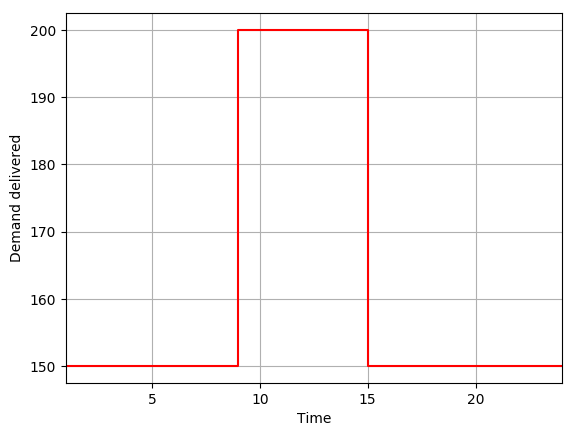

In [15]:
d_profile = getvalue(ddeliver)
step(time_grid,d_profile[:],color="red")
ax = gca()
ax[:set_xlim]([1,24])
xlabel("Time")
ylabel("Demand delivered")
grid("on")

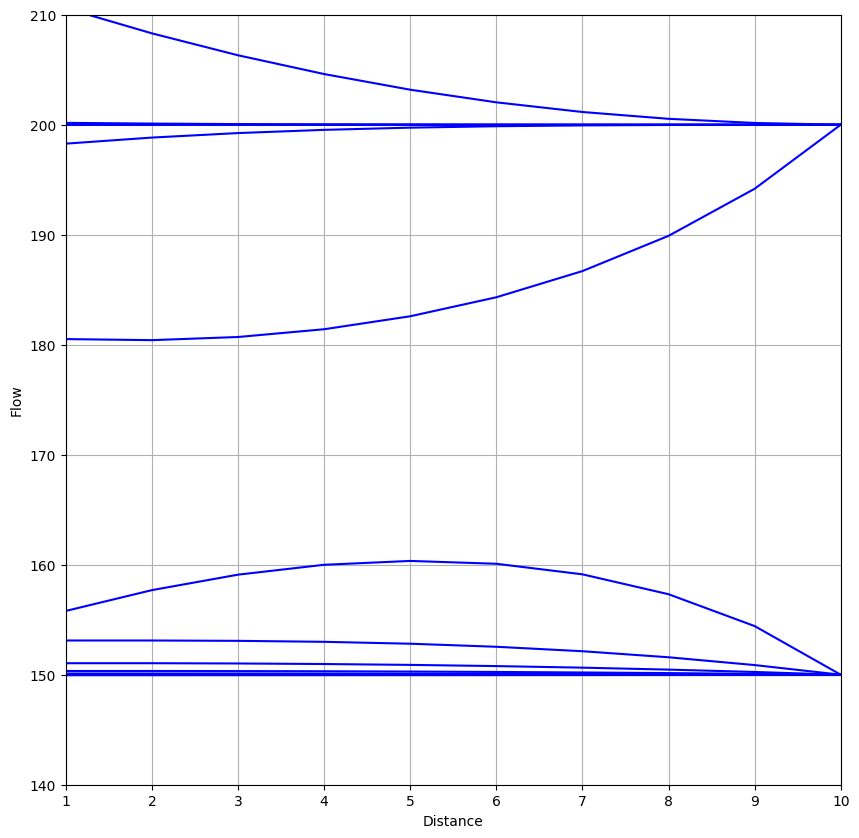

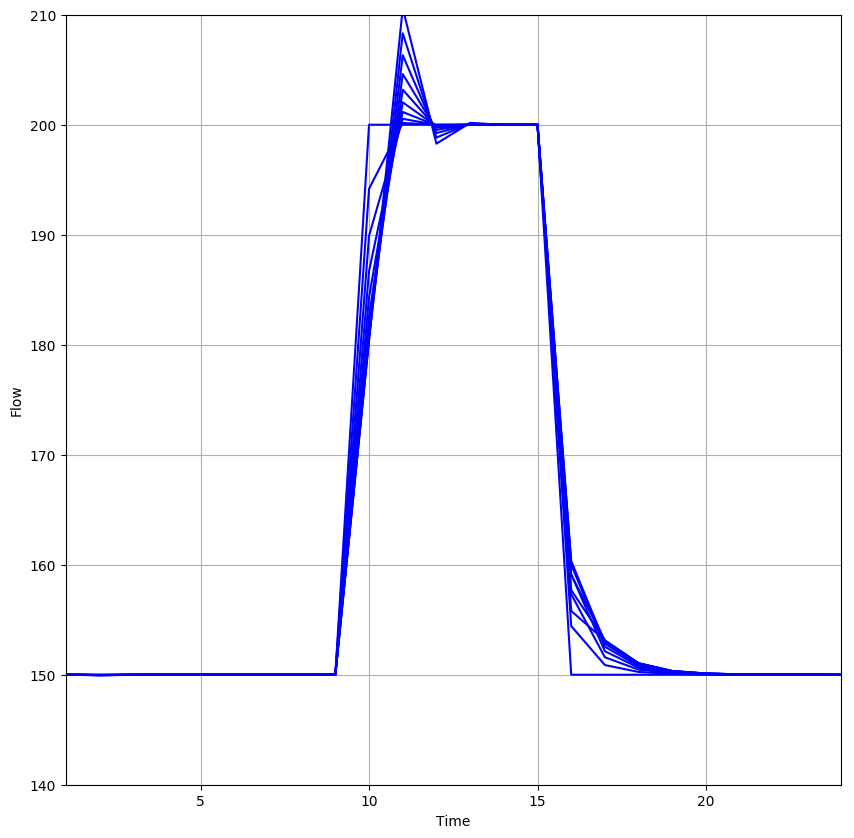

In [16]:
flow_profile = getvalue(fx)
fig = figure("pipeline_axial_flows",figsize=(10,10))
for t = time_grid
    plot(x_grid,flow_profile[t,:],color="blue")
    ax = gca()
    ax[:set_ylim]([140,210])
    ax[:set_xlim]([1,10])
    xlabel("Distance")
    ylabel("Flow")
end
grid("on")
fig = figure("pipeline_temporal_flows",figsize=(10,10))
for x = x_grid
    plot(time_grid,flow_profile[:,x],color="blue")
    ax = gca()
    ax[:set_ylim]([140,210])
    ax[:set_xlim]([1,24])
    xlabel("Time")
    ylabel("Flow")
end
grid("on")

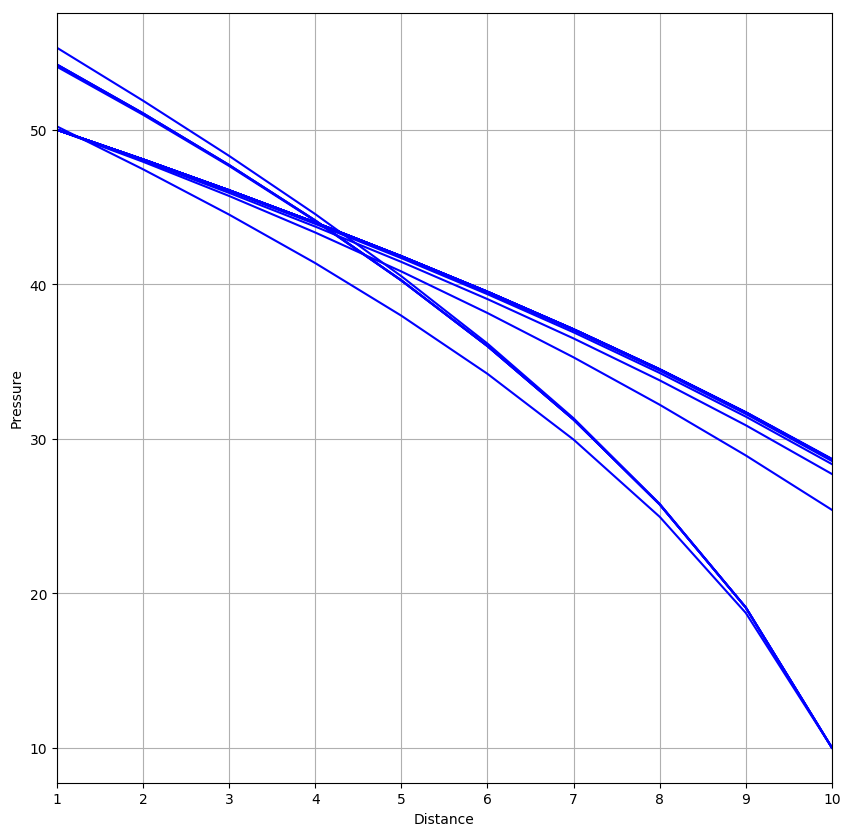

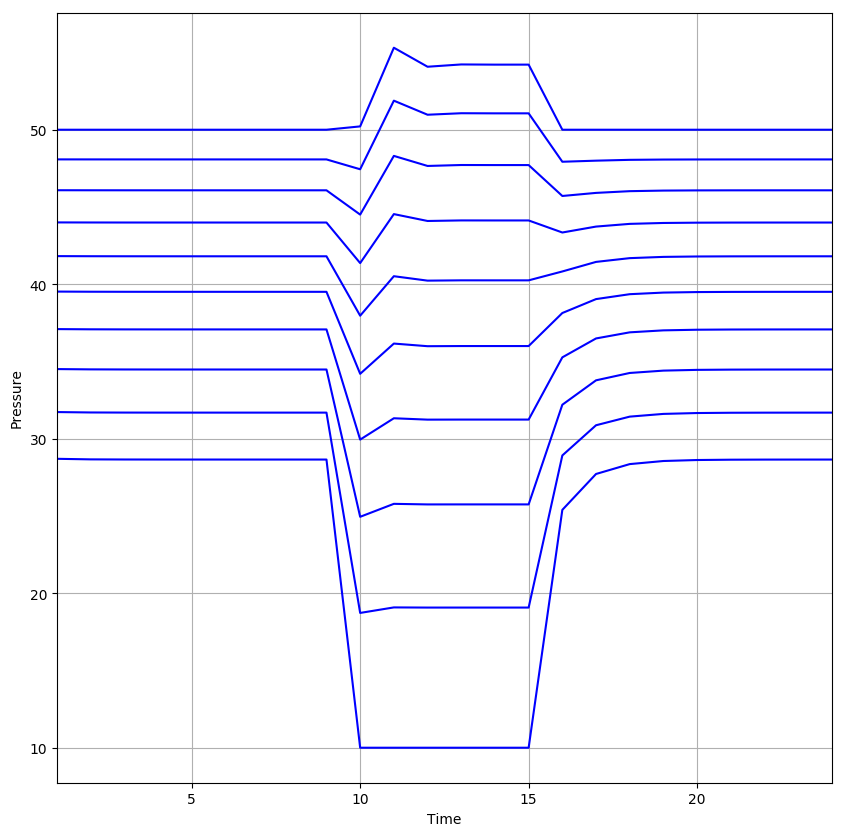

In [17]:
press_profile = getvalue(px)
fig = figure("pipeline_spatial_flows",figsize=(10,10))
for t = time_grid
    plot(x_grid,press_profile[t,:],color = "blue")
    ax = gca()
    ax[:set_xlim]([1,10])
    xlabel("Distance")
    ylabel("Pressure")
end
grid("on")
fig = figure("pipeline_temporal_flows",figsize=(10,10))
for x = x_grid
    plot(time_grid,press_profile[:,x],color = "blue")
    ax = gca()
    ax[:set_xlim]([1,24])
    xlabel("Time")
    ylabel("Pressure")
end
grid("on")